# Create interactive plots for the entire NS5 protein
To do this, we will concatenate the relevant datasets that have been generated for each tile. This means the per-tile analysis must be run before this analysis can be completed. 

First, we will concatenate the 'host_adapt' charts for each tile, which includes average mutation effect and differential selection data for each site in both our Huh-7.5-selected and C6-36-selected conditions. Then we will re-plot in Altair, and regenerate a list of most interesting muts for each selection condition  

In [3]:
# import necessary Python modules and packages
import glob
import os
import subprocess
import shutil

import Bio.SeqIO

import dms_tools2
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as CBPALETTE
import dms_tools2.prefs
import dms_tools2.utils
print(f"Using dms_tools2 {dms_tools2.__version__}")

from IPython.display import display, HTML

import pandas as pd

import altair as alt
from plotnine import *

import numpy

import dms_variants.plotnine_themes

Using dms_tools2 2.6.10


Disable max rows in Altair. This was leading to bug in chart generation step. 

In [4]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Create dictionary of pandas dataframes for each host_adaptation.csv file in each tile's results folder. 

In [5]:
# create a pandas dataframe for each tile 'host_adapt.csv'
results = '../results/'

d = {}

tile_list = ['tile_1', 'tile_2', 'tile_3', 'tile_4', 
             'tile_5', 'tile_6', 'tile_7', 'tile_8']

for tile in tile_list:
    tilepath = os.path.join(results + tile + "/muteffects/Huh-7.5_muteffects.csv")
    d[tile] = pd.read_csv(tilepath)


alltiles_hostadapt = pd.concat([d['tile_1'], d['tile_2'], d['tile_3'], d['tile_4'], 
                                d['tile_5'], d['tile_6'], d['tile_7'], d['tile_8']])

alltiles_hostadapt = (alltiles_hostadapt
                      # .replace(to_replace='conserved_site', value='conserved-site')
                     )
# alltiles_hostadapt.mutation_type.unique()

Now we can save the concatenated file in a new results folder. 

In [6]:
# create 'all_tiles' file within results folder
alltiles_dir = '../results/all_tiles'
os.makedirs(alltiles_dir, exist_ok=True)

# save concatenated dataframe as 'alltiles_host_adapt.csv'
alltiles_file = os.path.join(alltiles_dir + '/alltiles_host_adaptation.csv')
alltiles_hostadapt.to_csv(alltiles_file, index = False)
print('Saving concatenated data to "results/all_tiles/" folder. Here are first few lines...')
print(alltiles_hostadapt)

Saving concatenated data to "results/all_tiles/" folder. Here are first few lines...
      site wildtype mutant mutation    effect  log2effect
0        0        R      A      R0A  0.022474     -5.4756
1        0        R      C      R0C  0.010473     -6.5772
2        0        R      D      R0D  0.052421     -4.2537
3        0        R      E      R0E  0.040740     -4.6174
4        0        R      F      R0F  0.025003     -5.3218
...    ...      ...    ...      ...       ...         ...
2275   903        L      S    L903S  0.003768     -8.0519
2276   903        L      T    L903T  0.006104     -7.3560
2277   903        L      V    L903V  0.009205     -6.7634
2278   903        L      W    L903W  0.077963     -3.6811
2279   903        L      Y    L903Y  0.016852     -5.8909

[18080 rows x 6 columns]


Now we can produce the Altair charts like we did for the per-tile analysis for the entire E gene

## Make logoplot of mutational effects for Huh-7.5 NS5 
First we will write a file containing mutational effects for all tiles...

In [7]:
# Create directory for all-tile logoplots
alltiles_logodir = os.path.join(alltiles_dir, 'logoplots')
os.makedirs(alltiles_logodir, exist_ok=True)

# Make mutational effect file
for tile in tile_list:
    tilepath = os.path.join(results + tile + "/muteffects/Huh-7.5_muteffects.csv")
    d[tile] = pd.read_csv(tilepath)

alltiles_muteffects = pd.concat([d['tile_1'], d['tile_2'], d['tile_3'], d['tile_4'], 
                                d['tile_5'], d['tile_6'], d['tile_7'], d['tile_8']])
alltiles_muteffectsfile = os.path.join(alltiles_logodir, 'alltiles_muteffects.csv')
alltiles_muteffects.to_csv(alltiles_muteffectsfile, index=False)

# Make amino acid preferences file
for tile in tile_list:
    tilepath = os.path.join(results + tile + "/prefs/prefs_Huh-7.5.csv")
    d[tile] = pd.read_csv(tilepath)

alltiles_prefs = pd.concat([d['tile_1'], d['tile_2'], d['tile_3'], d['tile_4'], 
                                d['tile_5'], d['tile_6'], d['tile_7'], d['tile_8']])

# 'Add background back in at site 786'
alltiles_prefs.query('site == "786"').P
v = 0.97462
alltiles_prefs = alltiles_prefs.replace(v, v/100)

alltiles_prefsfile = os.path.join(alltiles_logodir, 'alltiles_prefs.csv')
alltiles_prefs.to_csv(alltiles_prefsfile, index=False)

In [8]:
name = 'NS5-Huh-7.5'

# Call dms2_logoplot for aa prefs
log = ! dms2_logoplot \
    --outdir {alltiles_logodir} \
    --ncpus 16 \
    --name {name} \
    --prefs {alltiles_prefsfile} \
    --use_existing 'yes'

# Call dms2_logoplot for mutational preferences
log = ! dms2_logoplot \
    --outdir {alltiles_logodir} \
    --ncpus 16 \
    --name {name} \
    --muteffects {alltiles_muteffectsfile} \
    --use_existing 'yes'

showing amino acid preferences for NS5 in Huh-7.5 cells...


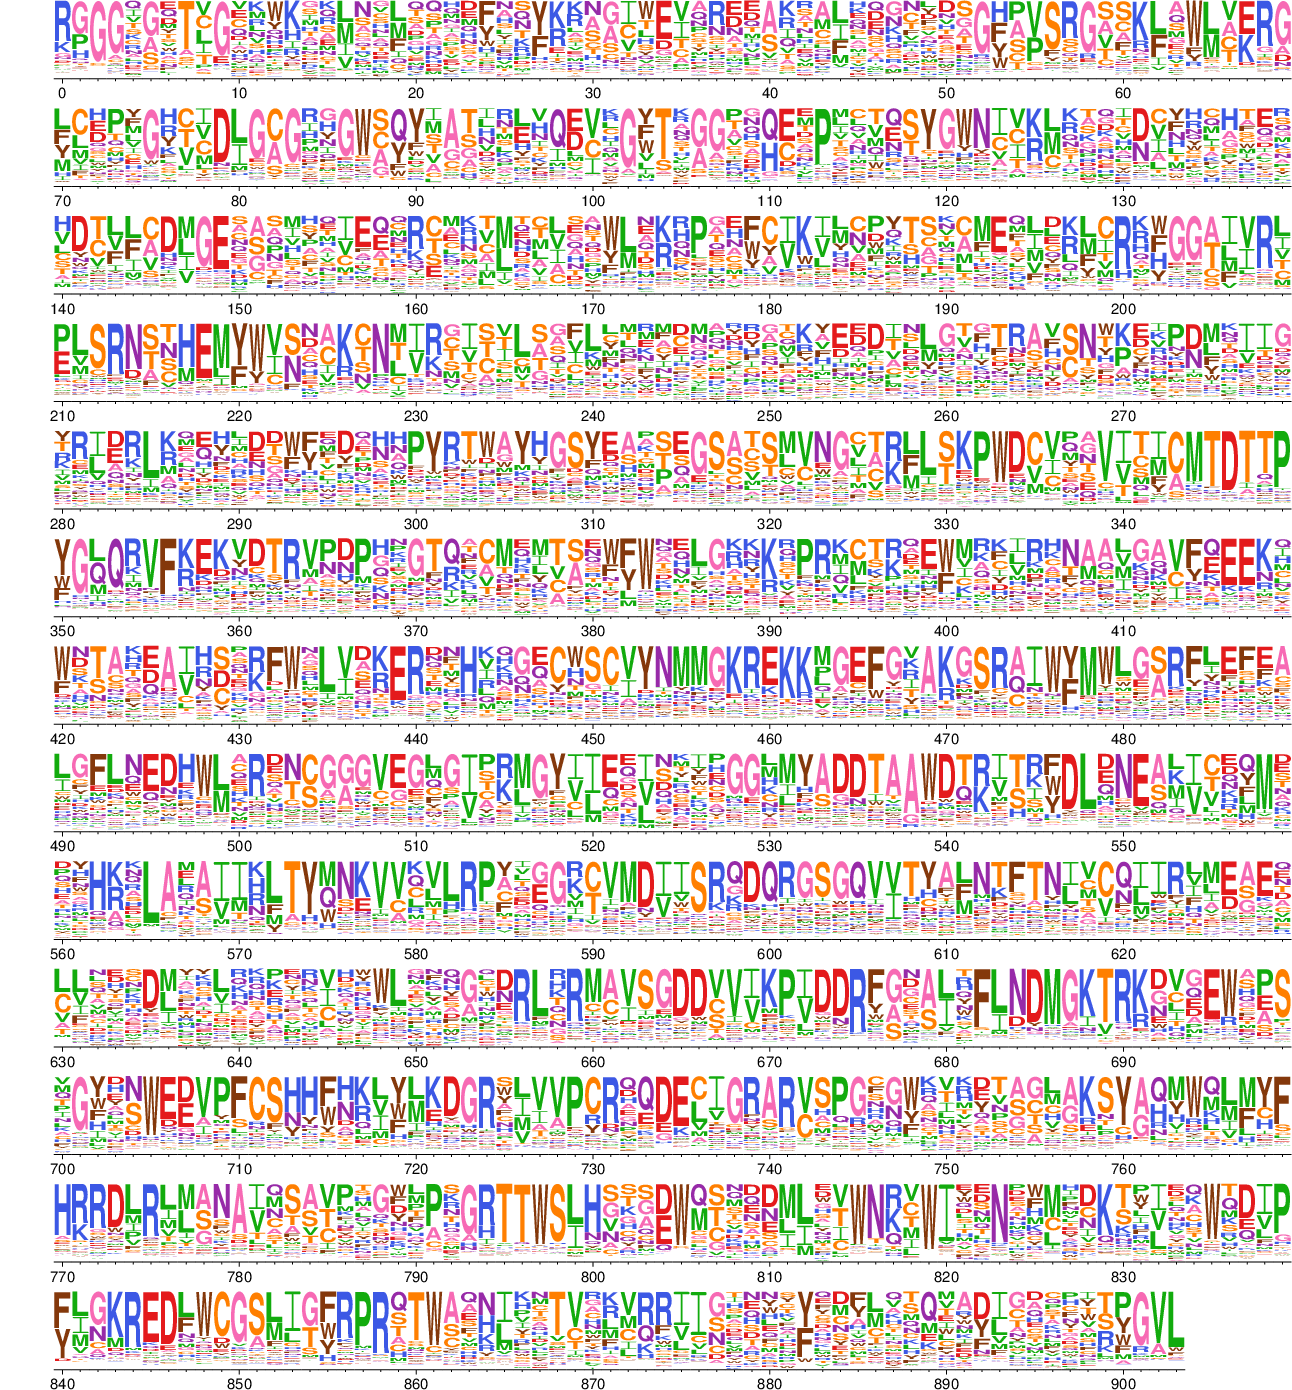

In [9]:
print('showing amino acid preferences for NS5 in Huh-7.5 cells...')
showPDF(os.path.join(alltiles_logodir, name + '_prefs.pdf'))

showing mutational tolerance for NS5 in Huh-7.5 cells...


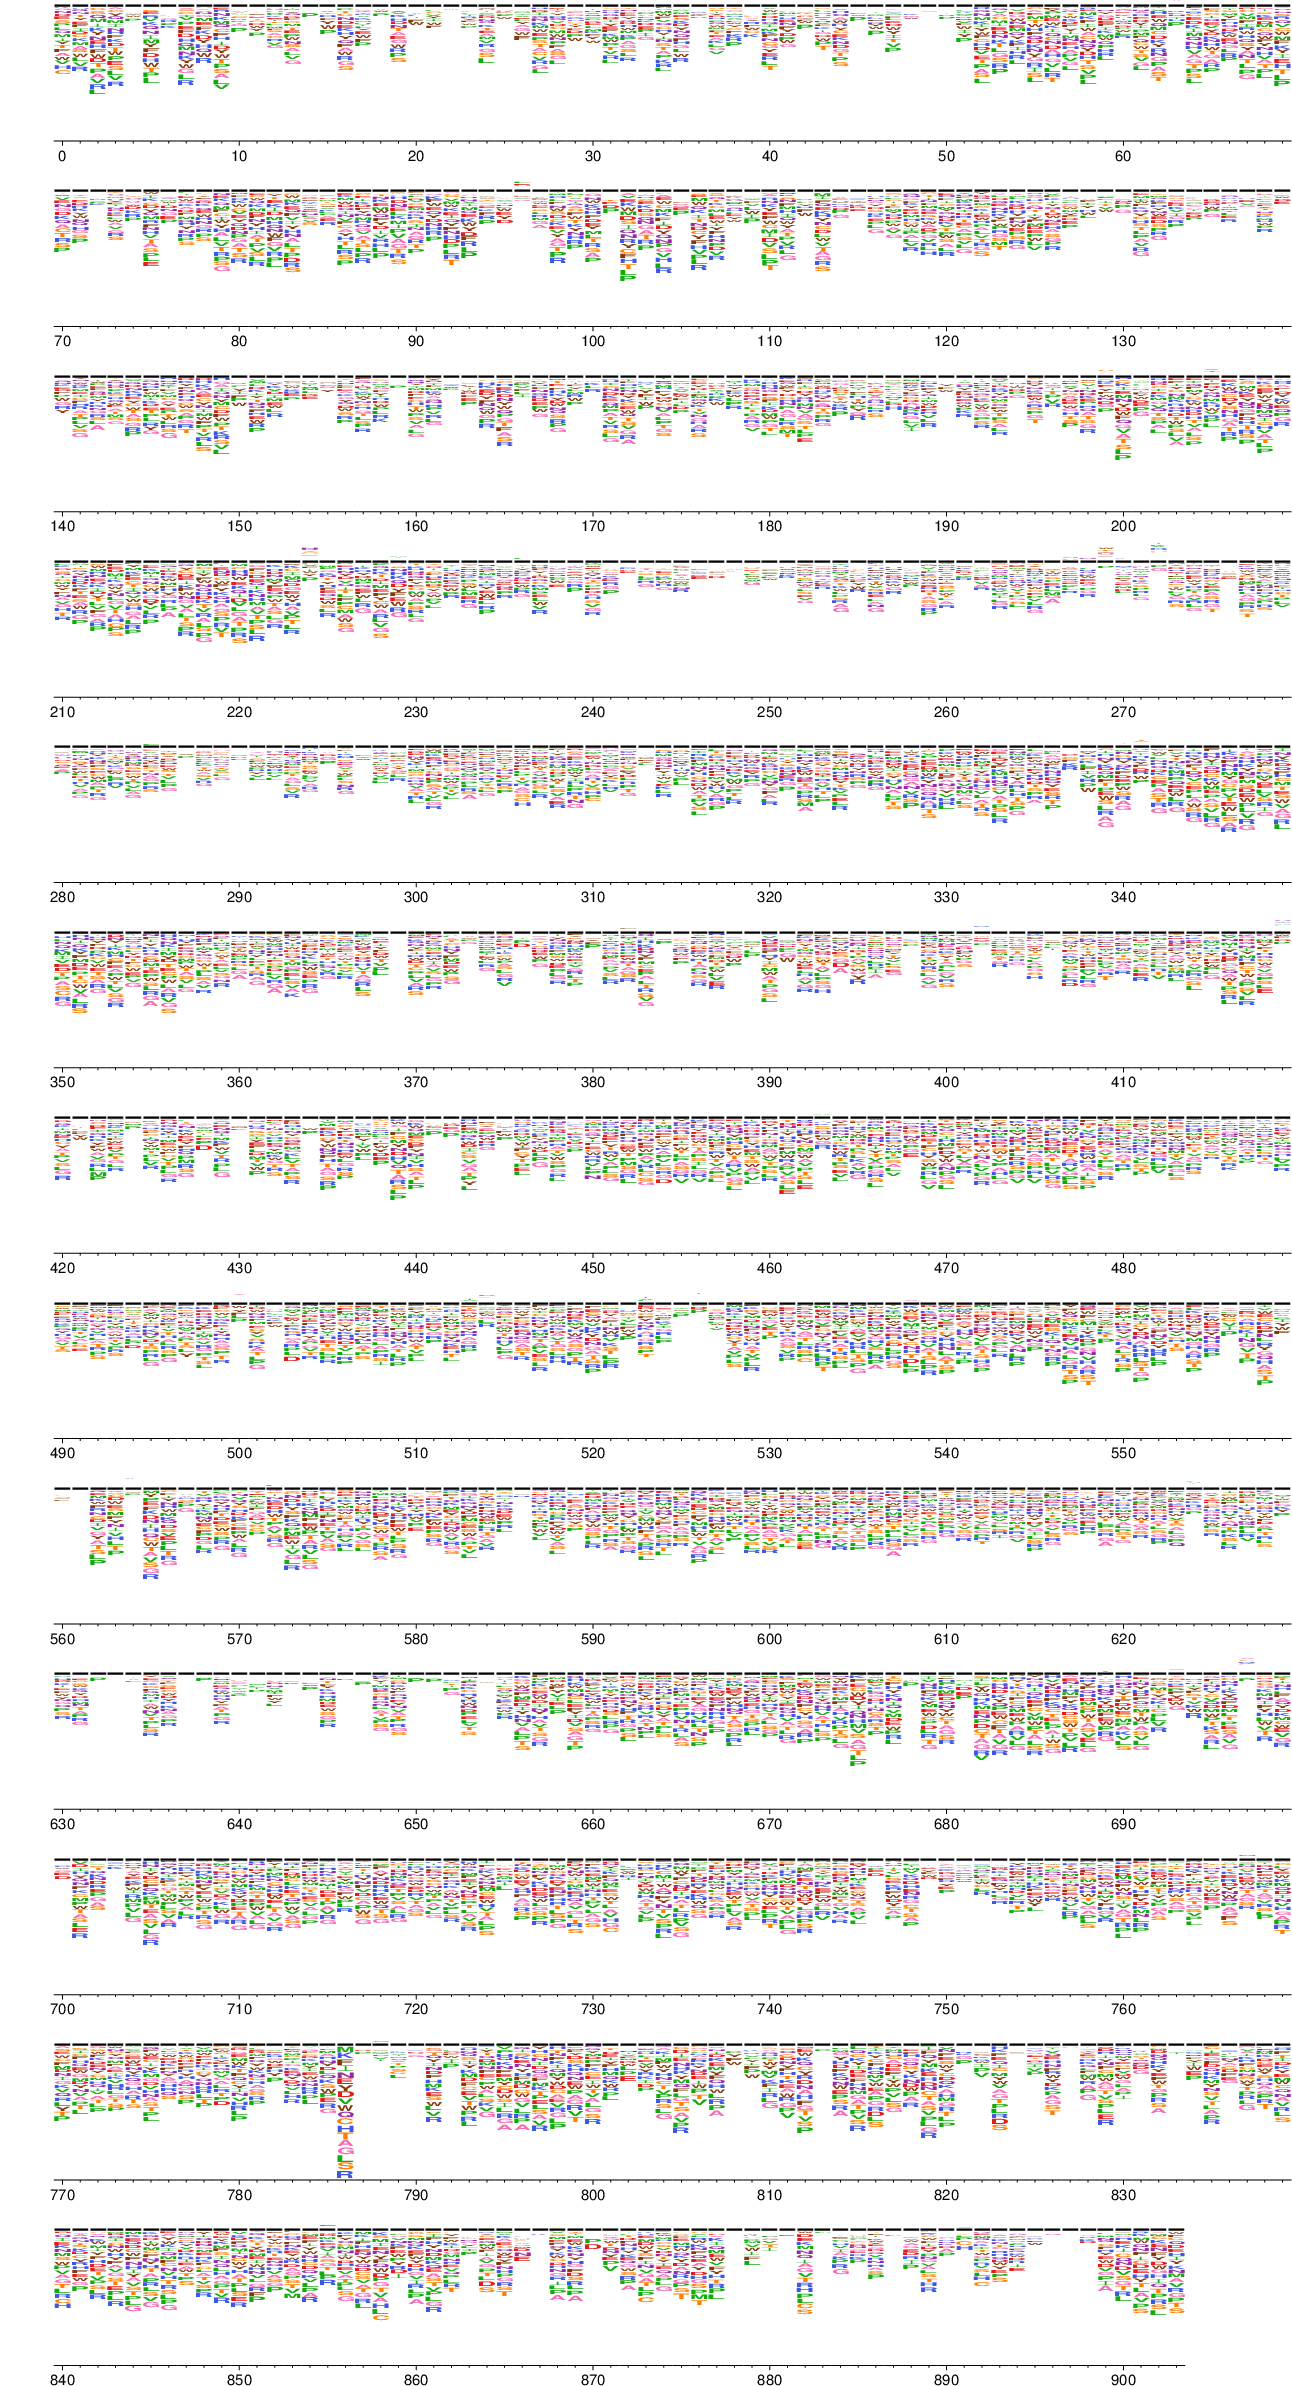

In [10]:
print('showing mutational tolerance for NS5 in Huh-7.5 cells...')
showPDF(os.path.join(alltiles_logodir, name + '_muteffects.pdf'))

## Make heatmaps of the same dataset

In [11]:
# Create directory for heatmaps
heatmapsdir = os.path.join(alltiles_dir, 'heatmaps/')
os.makedirs(heatmapsdir, exist_ok=True)

# Files to use
# alltiles_prefs
# alltiles_muteffects
# heatmapsdir

In [12]:
# Define heatmaps function
def get_heatmap(data, colorscheme='redblue', tooltip = ['mutation', 'effect', 'log2effect']):
    # Initialize empty list of charts
    charts = []
    # Intialize list of site ranges to plot so we don't have one massive heatmap
    ranges = [list(range(0,150)), list(range(150, 300)), list(range(300, 450)),
             list(range(450,600)), list(range(600, 750)), list(range(750, 904))]

    # Iterate through defined site ranges and make plots
    for r in ranges:
    
        # identify data
        range_data = (data[data['site'].isin(r)]
                      .query('site != 786') # IGNORE site 786
                     )
        
        
        heatmap = alt.Chart(range_data).mark_rect(stroke='black').encode(
            x = alt.X('site:O',
                      # sort = viruses,
                      axis=alt.Axis(labelFontSize=12, title="site")),
            y = alt.Y('mutant:O', 
                      axis=alt.Axis(labelFontSize=12, title="mutation")),
            color=alt.Color('log2effect:Q', scale = alt.Scale(
                # type='log',
                                                         scheme=colorscheme, domain=[-8, 8])
                           ),
            tooltip = tooltip
        ).interactive()
    
        charts.append(heatmap)
    
    plot = (alt.concat(*charts, title = '', columns = 1)
     # .resolve_scale(y='shared')
     .configure_title(fontSize=18)
     .configure_legend(titleFontSize=20, 
                       labelFontSize = 18,
                       strokeColor='gray',
                       # fillColor='#EEEEEE',
                       padding=10,
                       cornerRadius=10,
                       labelLimit = 500)
    )

    return plot

In [13]:
# Get muteffects heatmap 
muteffect_heatmap = get_heatmap(alltiles_muteffects)

outfile = os.path.join(heatmapsdir, 'muteffects_heatmap.html')
muteffect_heatmap.save(outfile)

In [14]:
# Get prefs heatmap

# Reshape prefs data
prefs_stacked = (pd.DataFrame(alltiles_prefs.set_index('site')
                                   .stack(
                                       # future_stack=True
                                   ), columns = ['pref'])
                        .reset_index()
                        .rename(columns = {'level_1': 'mutant'})

                )


prefs_heatmap = get_heatmap(prefs_stacked, colorscheme='lightgreyteal', tooltip = ['site', 'mutant', 'pref'])

outfile = os.path.join(heatmapsdir, 'prefs_heatmap.html')
prefs_heatmap.save(outfile)

## Write `docs` for GitHub Pages deployment

In [15]:
# Write index
# Copy specified plots and their description

In [19]:
def create_index_with_links(html_files, docs_dir="../docs"):
    """
    Create an index.html file linking to the specified HTML files.

    Parameters:
        html_files (list): List of paths to HTML files to be linked in the index.
        docs_dir (str): Directory where index.html and copies of the HTML files will be saved.
    """
    # Ensure the docs directory exists
    os.makedirs(docs_dir, exist_ok=True)

    # Prepare the HTML content for the index
    index_content = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>HTML Plots Index</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 20px;
        }
        h1 {
            font-size: 2em;
            color: #333;
        }
        h2 {
            font-size: 1.5em;
            color: #666;
        }
        p {
            font-size: 1em;
            color: #444;
        }
    </style>
</head>
<body>
    <h1>Plots Index</h1>
    <h2>Explore the following plots:</h2>
    <p>This page contains links to various plots. Click on a link below to view the corresponding plot.</p>
    <ul>
"""

    for html_file in html_files:
        # Copy each HTML file to the docs directory
        if os.path.exists(html_file):
            filename = os.path.basename(html_file)
            shutil.copy(html_file, os.path.join(docs_dir, filename))
            # Add a link to the file in the index
            index_content += f'        <li><a href="{filename}" target="_blank">{filename}</a></li>\n'
        else:
            print(f"Warning: File {html_file} does not exist and will be skipped.")

    # Close the HTML tags
    index_content += """    </ul>
</body>
</html>
"""

    # Write the index.html to the docs directory
    index_path = os.path.join(docs_dir, "index.html")
    with open(index_path, "w") as f:
        f.write(index_content)

    print(f"Index file created at: {index_path}")


In [20]:
# Example usage
html_files = [os.path.join(heatmapsdir, 'prefs_heatmap.html')]
create_index_with_links(html_files)


Index file created at: ../docs/index.html
